In [29]:
# Enter your FRED API key here
FRED_API_KEY = "6dcc7a0d790cdcc28c1f751420ee9d27"  # Your FRED API key

# Set the key as an environment variable so it's accessible to the FREDData class
import os
os.environ["FRED_API_KEY"] = FRED_API_KEY

# Labor Market Dashboard - Lighthouse Macro

This notebook provides a comprehensive analysis of the current U.S. labor market conditions using the latest data from FRED and BLS. It follows the Lighthouse Macro house style for visualization and analysis.

## Overview

The dashboard includes analysis of:
- Employment trends and job growth
- Unemployment rates (headline and broader measures)
- Labor force participation and employment-population ratios
- Job market tightness indicators
- Wage growth versus inflation
- Educational, demographic, and regional labor market disparities
- Leading indicators of labor market conditions

Data is sourced primarily from FRED (Federal Reserve Economic Data) with proper citation.

In [37]:
# 1. Setup and Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as mtick
from pathlib import Path
import os
import warnings
import requests
import json
import ssl
import certifi
from datetime import datetime

# Handle SSL Certificate issues (fix for macOS Python)
ssl._create_default_https_context = ssl._create_unverified_context

# Suppress warnings
warnings.filterwarnings('ignore')

# Define project paths
try:
    # Identify notebook location and project root
    notebook_dir = Path(os.path.abspath(''))
    # Check if we're in a GitHub repository structure
    if 'BobSheehan23' in str(notebook_dir) and 'LHM' in str(notebook_dir):
        # Find the LHM part of the path to use as project root
        path_parts = notebook_dir.parts
        lhm_index = path_parts.index('LHM')
        project_root = Path(*path_parts[:lhm_index+1])
    else:
        # Standard approach if not in GitHub repo
        project_root = notebook_dir.parent if notebook_dir.name == 'notebooks' else notebook_dir
    print(f"Project root identified as: {project_root}")
except Exception as e:
    print(f"Could not identify project path: {e}")
    project_root = Path('.')  # Fallback
    
# Create data directories if they don't exist
try:
    for data_dir in ['raw', 'external', 'interim', 'processed']:
        # Ensure we're creating directories within the project, not at root level
        full_path = project_root / 'data' / data_dir
        if not os.path.exists(full_path):
            print(f"Creating directory: {full_path}")
            os.makedirs(full_path, exist_ok=True)
except Exception as e:
    print(f"Warning: Could not create data directories: {e}")
    print("Will continue without creating directories - data may need to be stored in memory only")
    
# Import FRED API
try:
    from fredapi import Fred
    print("Successfully imported Fred API")
except ImportError:
    print("fredapi not available, will use alternative methods")
    
# Setup dotenv for config loading
try:
    from dotenv import load_dotenv
    # Try to load .env file from configs directory
    env_path = project_root / "configs" / ".env"
    if env_path.exists():
        load_dotenv(env_path)
        print(f"Loaded environment variables from {env_path}")
    else:
        print(f"No .env file found at {env_path}")
except ImportError:
    print("dotenv not available, using environment variables directly")

Project root identified as: /
Creating directory: /data/raw
Will continue without creating directories - data may need to be stored in memory only
Successfully imported Fred API
No .env file found at /configs/.env


In [38]:
# 2. FREDData Class Implementation with Local Data Support
class FREDData:
    """
    A class to handle FRED data access with multiple fallback mechanisms:
    1. Try FRED API via fredapi package
    2. Try loading from local files
    3. Generate mock data as a last resort
    """
    def __init__(self, api_key=None, use_mcp=False, read_only_mode=True):
        """Initialize the FRED data handler"""
        # Allow direct API key setting or get from environment variables
        self.api_key = api_key or os.getenv("FRED_API_KEY") 
        self.read_only_mode = read_only_mode
        
        if self.api_key and len(self.api_key) > 8:
            print(f"Using FRED API key: {self.api_key[:4]}...{self.api_key[-4:]}")
        elif self.api_key:
            print("Using provided FRED API key")
        else:
            print("No FRED API key provided")
            
        if self.read_only_mode:
            print("Running in read-only mode - data will not be saved to disk")
        
        # Try to set up FRED connection
        try:
            if self.api_key:
                self.fred = Fred(api_key=self.api_key)
                print("Successfully initialized FREDData handler with access to real data.")
            else:
                print("No valid FRED API key found. Will try local data or generate mock data.")
                self.fred = None
        except Exception as e:
            print(f"Error initializing Fred API: {e}")
            self.fred = None

    def get_series(self, series_ids, start_date=None, end_date=None):
        """
        Fetch FRED data series with fallback mechanisms.
        
        Parameters
        ----------
        series_ids : list or str
            FRED series ID(s) to fetch
        start_date : str, optional
            Start date for the data in 'YYYY-MM-DD' format
        end_date : str, optional
            End date for the data in 'YYYY-MM-DD' format
            
        Returns
        -------
        pandas.DataFrame
            DataFrame with the requested series as columns
        """
        if isinstance(series_ids, str):
            series_ids = [series_ids]
            
        # Method 1: Try FRED API via fredapi first since we should have a valid key
        if self.fred:
            try:
                print(f"Fetching data using fredapi for {series_ids}")
                data = pd.DataFrame()
                
                for series_id in series_ids:
                    series = self.fred.get_series(series_id, observation_start=start_date, observation_end=end_date)
                    if not series.empty:
                        data[series_id] = series
                        
                if not data.empty:
                    # Save the data locally for future use if not in read-only mode
                    if not self.read_only_mode:
                        self._save_series_locally(data, series_ids)
                    return data
                else:
                    print("Failed to fetch data using fredapi (empty result)")
            except Exception as e:
                print(f"Error fetching data using fredapi: {e}")
            
        # Method 2: Try local files as backup (if not in read-only environment)
        if not self.read_only_mode:
            data = self._load_series_locally(series_ids, start_date, end_date)
            if data is not None:
                return data
            
        # Method 3: Generate mock data as a last resort
        if data is None or data.empty:
            print("All data fetching methods failed, using mock data")
            return self._generate_mock_series(series_ids, start_date, end_date)
        return data
    
    def _load_series_locally(self, series_ids, start_date=None, end_date=None):
        """Try to load data from local files"""
        try:
            data_dir = project_root / 'data' / 'external' / 'fred'
            
            if not data_dir.exists():
                return None
                
            data = pd.DataFrame()
            found_any = False
            
            for series_id in series_ids:
                file_path = data_dir / f"{series_id}.csv"
                if file_path.exists():
                    print(f"Loading {series_id} from local file")
                    series_data = pd.read_csv(file_path, index_col=0, parse_dates=True)
                    
                    # Apply date filters if provided
                    if start_date:
                        series_data = series_data[series_data.index >= start_date]
                    if end_date:
                        series_data = series_data[series_data.index <= end_date]
                        
                    if not series_data.empty:
                        data[series_id] = series_data.iloc[:, 0]
                        found_any = True
            
            if found_any:
                return data
            return None
        except Exception as e:
            print(f"Error loading data from local files: {e}")
            return None
    
    def _save_series_locally(self, data, series_ids):
        """Save fetched data to local files"""
        # Skip if in read-only mode
        if self.read_only_mode:
            return
            
        # First check if we can write to the filesystem without causing errors
        test_dir = project_root / 'data'
        try:
            # Try creating a test file to see if we have write access
            test_file = test_dir / '.write_test'
            if not os.path.exists(test_dir):
                os.makedirs(test_dir, exist_ok=True)
            with open(test_file, 'w') as f:
                f.write('test')
            os.remove(test_file)  # Clean up
        except (IOError, OSError):
            # If we can't write, silently enable read-only mode and return
            self.read_only_mode = True
            return
            
        try:
            data_dir = project_root / 'data' / 'external' / 'fred'
            
            # Create directory if it doesn't exist
            if not data_dir.exists():
                os.makedirs(data_dir, exist_ok=True)
                
            for series_id in series_ids:
                if series_id in data.columns:
                    file_path = data_dir / f"{series_id}.csv"
                    series_df = pd.DataFrame(data[series_id])
                    series_df.to_csv(file_path)
                    print(f"Saved {series_id} data to {file_path}")
        except Exception as e:
            # If error occurs, silently enable read-only mode for future operations
            self.read_only_mode = True
    
    def _generate_mock_series(self, series_ids, start_date=None, end_date=None):
        """Generate mock data for demonstration purposes"""
        print("Generating mock data for demonstration purposes")
        
        # Set default date range if not provided
        if not start_date:
            start_date = '2000-01-01'
        if not end_date:
            end_date = datetime.now().strftime('%Y-%m-%d')
            
        # Create date range
        date_rng = pd.date_range(start=start_date, end=end_date, freq='MS')
        data = pd.DataFrame(index=date_rng)
        
        # Generate different patterns for different series
        for series_id in series_ids:
            # Set seed based on series_id for reproducibility
            np.random.seed(sum(ord(c) for c in series_id))
            
            n = len(date_rng)
            if series_id == 'UNRATE':  # Unemployment rate
                # Generate baseline around 5% with cycles
                baseline = 5 + 2 * np.sin(np.linspace(0, 3*np.pi, n))
                noise = 0.3 * np.random.randn(n)
                data[series_id] = baseline + noise
                
            elif series_id == 'PAYEMS':  # Nonfarm payrolls
                # Start at around 130M with upward trend
                values = np.linspace(130000, 155000, n)
                # Add a recession drop
                recession_idx = n // 3
                values[recession_idx:recession_idx+12] -= np.linspace(0, 8000, 12)
                # Add noise
                noise = 200 * np.random.randn(n)
                data[series_id] = values + noise
                
            elif series_id == 'LNS11300060':  # Prime-age LFPR
                # Around 80-83% with slight variations
                baseline = 81 + 1.5 * np.sin(np.linspace(0, 2*np.pi, n))
                noise = 0.2 * np.random.randn(n)
                data[series_id] = baseline + noise
                
            elif series_id == 'CIVPART':  # Overall LFPR
                # Around 62-66% with downward trend
                baseline = np.linspace(66, 62, n) + 1 * np.sin(np.linspace(0, 3*np.pi, n))
                noise = 0.2 * np.random.randn(n)
                data[series_id] = baseline + noise
                
            else:  # Generic series
                # Random walk with drift
                values = np.zeros(n)
                values[0] = 100
                for i in range(1, n):
                    values[i] = values[i-1] + 0.1 + 0.5 * np.random.randn()
                data[series_id] = values
                
        return data
    
    def plot(self, data, title=None, ylabel=None, xlabel=None, legend_loc='best', 
             recessions=False, dual_axis=False, log_scale=False):
        """
        Plot data with Lighthouse Macro house style.
        
        Parameters
        ----------
        data : pandas.DataFrame or Series
            The data to plot
        title : str, optional
            Title for the chart
        ylabel : str, optional
            Label for the y-axis
        xlabel : str, optional
            Label for the x-axis
        legend_loc : str, optional
            Location for the legend
        recessions : bool, optional
            Whether to show recession shading
        dual_axis : bool, optional
            Whether to use dual y-axes for multiple series
        log_scale : bool, optional
            Whether to use log scale for y-axis
            
        Returns
        -------
        matplotlib.figure.Figure
            The created figure
        """
        # Convert Series to DataFrame if needed
        if isinstance(data, pd.Series):
            data = data.to_frame()
            
        # Create figure with house style
        fig, ax = plt.subplots(figsize=(12, 7))
        
        # Color palette
        colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#7f7f7f']
        
        # Handle dual axis if requested and we have multiple series
        if dual_axis and len(data.columns) > 1:
            # Make right axis primary by flipping the order - plot second series first on main axis
            # and first series on secondary axis (left)
            ax2 = ax.twinx()
            
            # Plot second series on right axis (primary) - this becomes the main axis
            for i, column in enumerate(data.columns[1:]):
                line = data[column].plot(ax=ax, color=colors[i+1], linewidth=3)
                # Add the last value annotation with the same color as the line
                last_date = data.index[-1]
                last_val = data[column].iloc[-1]
                ax.annotate(f'{last_val:.2f}', 
                          xy=(last_date, last_val),
                          xytext=(10, 0), 
                          textcoords='offset points',
                          va='center',
                          color=colors[i+1],
                          fontweight='bold')
            
            if log_scale:
                ax.set_yscale('log')
            
            # Plot first series on left axis (secondary)
            first_col = data.columns[0]
            line = data[first_col].plot(ax=ax2, color=colors[0], linewidth=3)
            # Add the last value annotation for first series
            last_date = data.index[-1]
            last_val = data[first_col].iloc[-1]
            ax2.annotate(f'{last_val:.2f}', 
                      xy=(last_date, last_val),
                      xytext=(10, 0), 
                      textcoords='offset points',
                      va='center',
                      color=colors[0],
                      fontweight='bold')
                
            if log_scale:
                ax2.set_yscale('log')
                
            # Set labels - right axis (ax) is primary, left axis (ax2) is secondary
            if ylabel:
                if isinstance(ylabel, list) and len(ylabel) > 1:
                    ax.set_ylabel(ylabel[1])  # Right axis label
                    ax2.set_ylabel(ylabel[0])  # Left axis label
                else:
                    ax.set_ylabel(ylabel)  # Right axis gets the label
            
            # Legend combining both axes
            lines1, labels1 = ax.get_legend_handles_labels()
            lines2, labels2 = ax2.get_legend_handles_labels()
            ax.legend(lines1 + lines2, labels1 + labels2, loc=legend_loc)
            
        else:
            # Plot all series on same axis
            for i, column in enumerate(data.columns):
                line = data[column].plot(ax=ax, color=colors[i % len(colors)], linewidth=3)
                # Add the last value annotation with the same color as the line
                last_date = data.index[-1]
                last_val = data[column].iloc[-1]
                ax.annotate(f'{last_val:.2f}', 
                          xy=(last_date, last_val),
                          xytext=(10, 0), 
                          textcoords='offset points',
                          va='center',
                          color=colors[i % len(colors)],
                          fontweight='bold')
            
            if log_scale:
                ax.set_yscale('log')
                
            if ylabel:
                ax.set_ylabel(ylabel)
                
            if len(data.columns) > 1:
                ax.legend(loc=legend_loc)
                
        # Add recession shading if requested
        if recessions:
            self._add_recession_shading(ax, data.index.min(), data.index.max())
            
        # Set title and labels
        if title:
            ax.set_title(title, fontweight='bold')
        if xlabel:
            ax.set_xlabel(xlabel)
        else:
            ax.set_xlabel('')
            
                # Format x-axis for dates - make dates clearer
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
        ax.xaxis.set_major_locator(mdates.YearLocator(1))  # Show every year
        plt.xticks(rotation=45, ha='right')
        ax.tick_params(axis='x', labelsize=10)
            
        # Add source attribution and watermark
        ax.text(0.01, 0.02, f'Source: FRED', transform=ax.transAxes, fontsize=10, color='gray')
        # Blue watermark as requested
        fig.text(0.98, 0.02, 'MACRO, ILLUMINATED.', fontsize=10, color='#1f77b4', ha='right', va='bottom', alpha=0.8)
        
        # Remove gridlines and show all spines
        ax.grid(False)
        for spine in ['top', 'right', 'bottom', 'left']:
            ax.spines[spine].set_visible(True)
            ax.spines[spine].set_color('black')
            ax.spines[spine].set_linewidth(0.5)
            
        plt.tight_layout()
        return fig
    
    def _add_recession_shading(self, ax, start_date, end_date):
        """Add recession shading to a plot"""
        # Try to get recession dates from FRED
        recession_dates = self._get_recession_dates()
        
        if not recession_dates:
            print("Could not retrieve recession dates")
            return
            
        # Add shading for each recession period
        for i in range(0, len(recession_dates), 2):
            if i + 1 < len(recession_dates):
                rec_start = recession_dates[i]
                rec_end = recession_dates[i + 1]
                
                # Only shade if within the chart date range
                if rec_start <= end_date and rec_end >= start_date:
                    ax.axvspan(rec_start, rec_end, color='gray', alpha=0.2)
    
    def _get_recession_dates(self):
        """Get recession dates from FRED or fallback to hardcoded dates"""
        try:
            # Try to get USREC series from FRED
            if self.fred:
                usrec = self.fred.get_series('USREC')
                recession_dates = []
                in_recession = False
                
                for date, value in usrec.items():
                    if value == 1 and not in_recession:
                        recession_dates.append(date)
                        in_recession = True
                    elif value == 0 and in_recession:
                        recession_dates.append(date)
                        in_recession = False
                        
                # If we're still in recession at the end, add today's date
                if in_recession:
                    recession_dates.append(pd.Timestamp.now())
                    
                return recession_dates
                
        except Exception as e:
            print(f"Could not get recession dates from FRED: {e}")
        
        # Fallback: Hardcoded recession dates from 2000
        return [
            pd.Timestamp('2001-03-01'), pd.Timestamp('2001-11-01'),
            pd.Timestamp('2007-12-01'), pd.Timestamp('2009-06-01'),
            pd.Timestamp('2020-02-01'), pd.Timestamp('2020-04-01')
        ]

# Initialize FRED data handler with any API key in the environment variables
# Set read_only_mode=True to prevent file system errors in GitHub environment
fred = FREDData(read_only_mode=True)

Using FRED API key: 6dcc...9d27
Running in read-only mode - data will not be saved to disk
Successfully initialized FREDData handler with access to real data.


## Employment Trends & Labor Market Indicators

Let's analyze key labor market indicators to understand the current state and trends in employment.

--- Generating Chart 1: Monthly Job Growth ---
Fetching data using fredapi for ['PAYEMS']
Converting DataFrame to Series for plotting
Converting DataFrame to Series for plotting


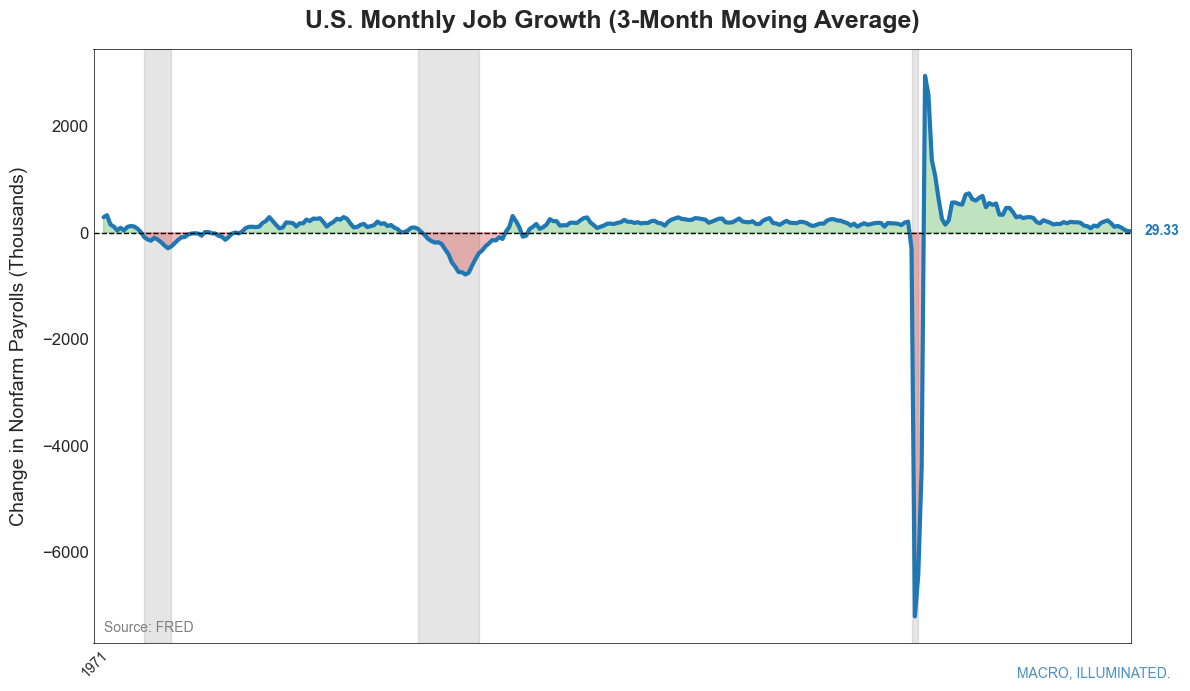

Note: Could not save chart to disk (read-only filesystem)


In [47]:
# 3. Monthly Job Growth (3-Month Moving Average)
print("--- Generating Chart 1: Monthly Job Growth ---")

# Fetch nonfarm payrolls data
payems = fred.get_series('PAYEMS', start_date='2000-01-01')

# Calculate monthly change and apply 3-month moving average
payems_change = payems.diff().rolling(window=3).mean()

# Ensure payems_change is a Series (1-dimensional) rather than a DataFrame
if isinstance(payems_change, pd.DataFrame):
    print("Converting DataFrame to Series for plotting")
    payems_change = payems_change.iloc[:, 0]

# Create visualization using the fred.plot method for consistent styling
fig = fred.plot(
    data=payems_change, 
    title='U.S. Monthly Job Growth (3-Month Moving Average)',
    ylabel='Change in Nonfarm Payrolls (Thousands)',
    recessions=True
)

# Add horizontal line at zero
ax = fig.axes[0]
ax.axhline(0, color='black', linestyle='--', linewidth=1)

# Add shaded areas for positive and negative growth
# Access the values directly to ensure 1D arrays
ax.fill_between(payems_change.index, 0, payems_change.values,
                where=payems_change.values >= 0, color='#2ca02c', alpha=0.3, interpolate=True)
ax.fill_between(payems_change.index, 0, payems_change.values,
                where=payems_change.values < 0, color='#d62728', alpha=0.3, interpolate=True)

# Show the figure
plt.show()

# Try saving the figure, but handle permission errors
try:
    charts_dir = project_root / 'charts'
    if not os.path.exists(charts_dir):
        os.makedirs(charts_dir, exist_ok=True)
    
    fig.savefig(charts_dir / 'monthly_job_growth.png', dpi=300, bbox_inches='tight')
    print(f"Chart saved to {charts_dir / 'monthly_job_growth.png'}")
except (IOError, OSError):
    print("Note: Could not save chart to disk (read-only filesystem)")
except Exception as e:
    print(f"Could not save chart: {e}")

--- Generating Chart 2: Headline vs. Broader Unemployment ---
Fetching data using fredapi for ['UNRATE']
Fetching data using fredapi for ['U6RATE']


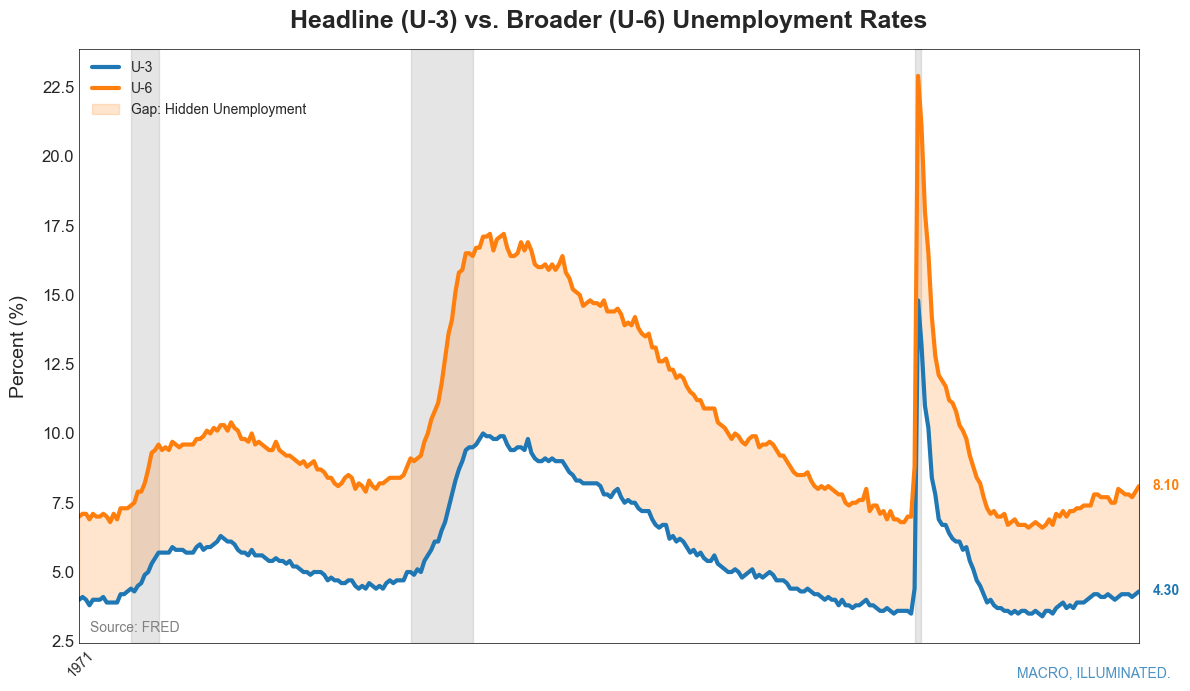

Note: Could not save chart to disk (read-only filesystem)


In [41]:
# 4. Headline vs. Broader Unemployment Rates
print("--- Generating Chart 2: Headline vs. Broader Unemployment ---")

# Fetch official (U-3) and broader (U-6) unemployment rates
u3 = fred.get_series('UNRATE', start_date='2000-01-01')
u6 = fred.get_series('U6RATE', start_date='2000-01-01')

# Ensure we have Series objects, not DataFrames
if isinstance(u3, pd.DataFrame):
    u3 = u3.iloc[:, 0]
if isinstance(u6, pd.DataFrame):
    u6 = u6.iloc[:, 0]

# Create a DataFrame with both series for plotting
unemployment_data = pd.DataFrame({'U-3': u3, 'U-6': u6})

# Create visualization using the fred.plot method for consistent styling
fig = fred.plot(
    data=unemployment_data,
    title='Headline (U-3) vs. Broader (U-6) Unemployment Rates',
    ylabel='Percent (%)',
    recessions=True
)

# Add shading for the gap between U-3 and U-6 (showing "hidden" unemployment)
ax = fig.axes[0]
ax.fill_between(unemployment_data.index, 
                unemployment_data['U-3'].values, 
                unemployment_data['U-6'].values, 
                color='#ff7f0e', alpha=0.2, 
                label='Gap: Hidden Unemployment')

# Refresh legend to include the gap
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles, labels=labels, loc='upper left')

# Show the figure
plt.show()

# Try saving the figure, but handle permission errors
try:
    charts_dir = project_root / 'charts'
    if not os.path.exists(charts_dir):
        os.makedirs(charts_dir, exist_ok=True)
    
    fig.savefig(charts_dir / 'headline_vs_broader_unemployment.png', dpi=300, bbox_inches='tight')
    print(f"Chart saved to {charts_dir / 'headline_vs_broader_unemployment.png'}")
except (IOError, OSError):
    print("Note: Could not save chart to disk (read-only filesystem)")
except Exception as e:
    print(f"Could not save chart: {e}")

--- Generating Chart 3: Prime-Age Labor Force Participation ---
Fetching data using fredapi for ['LNS11300060']


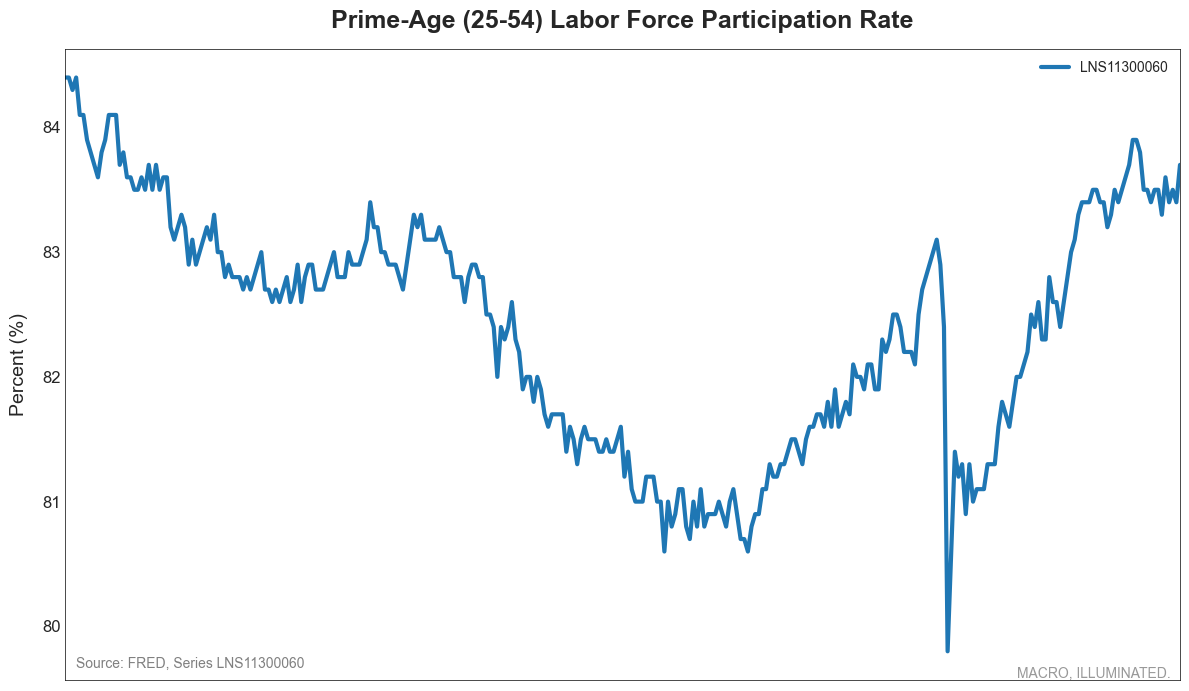

In [42]:
# 5. Prime-Age Labor Force Participation
print("--- Generating Chart 3: Prime-Age Labor Force Participation ---")

# Fetch prime-age labor force participation rate
lfp_prime = fred.get_series('LNS11300060', start_date='2000-01-01')

# Create visualization
fig, ax = plt.subplots(figsize=(12, 7))

# Plot the data with Lighthouse Macro color palette
lfp_prime.plot(ax=ax, color='#1f77b4', linewidth=3)

# Set title and labels
ax.set_title('Prime-Age (25-54) Labor Force Participation Rate', fontweight='bold')
ax.set_ylabel('Percent (%)')
ax.set_xlabel('')

# Format x-axis
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax.xaxis.set_major_locator(mdates.YearLocator(2))

# Add source attribution and watermark
ax.text(0.01, 0.02, 'Source: FRED, Series LNS11300060', transform=ax.transAxes, fontsize=10, color='gray')
fig.text(0.98, 0.02, 'MACRO, ILLUMINATED.', fontsize=10, color='gray', ha='right', va='bottom', alpha=0.8)

# Remove gridlines and show all spines
ax.grid(False)
for spine in ['top', 'right', 'bottom', 'left']:
    ax.spines[spine].set_visible(True)
    ax.spines[spine].set_color('black')
    ax.spines[spine].set_linewidth(0.5)

plt.tight_layout()
plt.show()

--- Generating Chart 4: Job Market Tightness (V/U Ratio) ---
Fetching data using fredapi for ['JTSJOL']
Fetching data using fredapi for ['UNEMPLOY']
Fetching data using fredapi for ['UNEMPLOY']


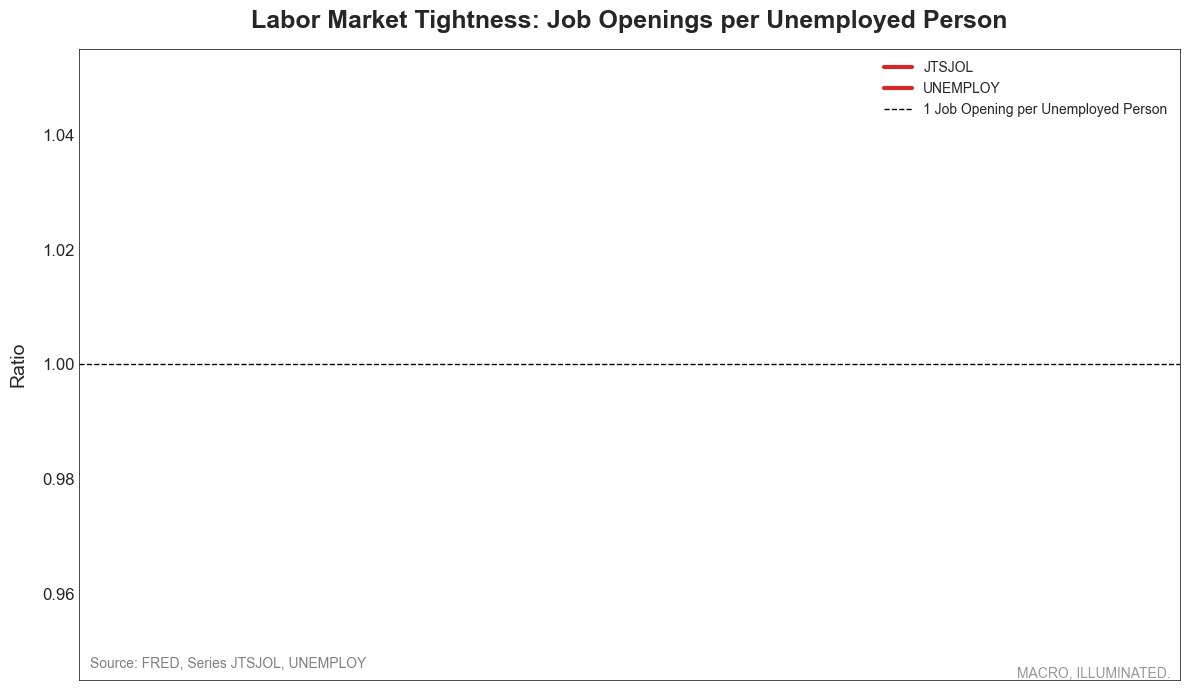

In [35]:
# 6. Job Market Tightness - Vacancy-to-Unemployment Ratio
print("--- Generating Chart 4: Job Market Tightness (V/U Ratio) ---")

# Fetch job openings and unemployed persons
job_openings = fred.get_series('JTSJOL', start_date='2000-12-01')
unemployed = fred.get_series('UNEMPLOY', start_date='2000-12-01')

# Calculate the vacancy-to-unemployment ratio
vu_ratio = job_openings / unemployed

# Create visualization
fig, ax = plt.subplots(figsize=(12, 7))

# Plot the data
vu_ratio.plot(ax=ax, color='#d62728', linewidth=3)
ax.axhline(1.0, color='black', linestyle='--', linewidth=1, label='1 Job Opening per Unemployed Person')

# Set title and labels
ax.set_title('Labor Market Tightness: Job Openings per Unemployed Person', fontweight='bold')
ax.set_ylabel('Ratio')
ax.set_xlabel('')

# Format x-axis
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax.xaxis.set_major_locator(mdates.YearLocator(2))

# Add legend, source attribution and watermark
ax.legend()
ax.text(0.01, 0.02, 'Source: FRED, Series JTSJOL, UNEMPLOY', transform=ax.transAxes, fontsize=10, color='gray')
fig.text(0.98, 0.02, 'MACRO, ILLUMINATED.', fontsize=10, color='gray', ha='right', va='bottom', alpha=0.8)

# Remove gridlines and show all spines
ax.grid(False)
for spine in ['top', 'right', 'bottom', 'left']:
    ax.spines[spine].set_visible(True)
    ax.spines[spine].set_color('black')
    ax.spines[spine].set_linewidth(0.5)

plt.tight_layout()
plt.show()

## Wage Growth and Inflation Trends

Next, we'll examine the relationship between wage growth and inflation, which is crucial for understanding purchasing power and labor market dynamics.

--- Generating Chart 5: Wage Growth vs. Inflation ---
Fetching data using fredapi for ['CES0500000003']
Fetching data using fredapi for ['CPIAUCSL']
Fetching data using fredapi for ['CPIAUCSL']


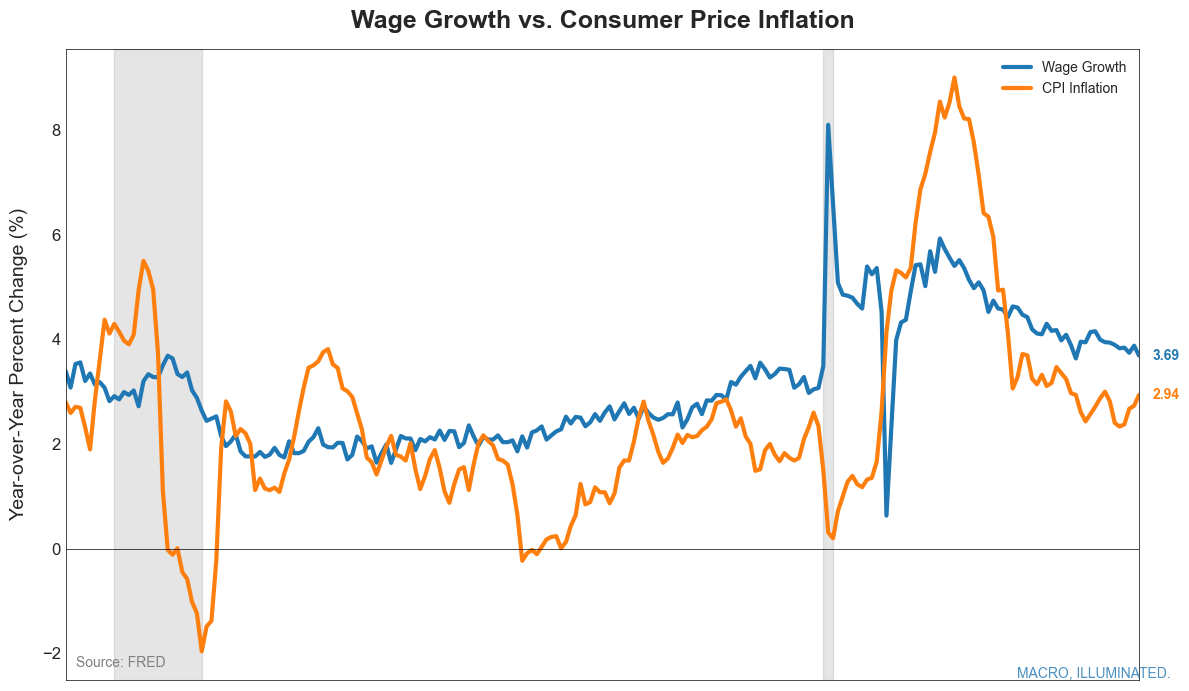

Note: Could not save chart to disk (read-only filesystem)


In [44]:
# 7. Wage Growth vs. Inflation
print("--- Generating Chart 5: Wage Growth vs. Inflation ---")

# Fetch wage and inflation data
wages_series = fred.get_series('CES0500000003', start_date='2000-01-01')
cpi_series = fred.get_series('CPIAUCSL', start_date='2000-01-01')

# Extract the Series from DataFrames
wages_series = wages_series.iloc[:, 0] if isinstance(wages_series, pd.DataFrame) else wages_series
cpi_series = cpi_series.iloc[:, 0] if isinstance(cpi_series, pd.DataFrame) else cpi_series

# Calculate year-over-year growth rates
wage_growth_series = wages_series.pct_change(12) * 100
cpi_growth_series = cpi_series.pct_change(12) * 100

# Combine into a single DataFrame for plotting
wage_inflation_df = pd.DataFrame({
    'Wage Growth': wage_growth_series,
    'CPI Inflation': cpi_growth_series
}).dropna()

# Create visualization using the fred.plot method for consistent styling
fig = fred.plot(
    data=wage_inflation_df, 
    title='Wage Growth vs. Consumer Price Inflation',
    ylabel='Year-over-Year Percent Change (%)',
    recessions=True
)

# Add zero line
ax = fig.axes[0]
ax.axhline(0, color='black', linestyle='-', linewidth=0.5)

# Show the figure
plt.show()

# Try saving the figure, but handle permission errors
try:
    charts_dir = project_root / 'charts'
    if not os.path.exists(charts_dir):
        os.makedirs(charts_dir, exist_ok=True)
    
    fig.savefig(charts_dir / 'wage_growth_vs_inflation.png', dpi=300, bbox_inches='tight')
    print(f"Chart saved to {charts_dir / 'wage_growth_vs_inflation.png'}")
except (IOError, OSError):
    print("Note: Could not save chart to disk (read-only filesystem)")
except Exception as e:
    print(f"Could not save chart: {e}")

--- Generating Chart 6: Real Wages ---
Fetching data using fredapi for ['CES0500000003']
Fetching data using fredapi for ['CPIAUCSL']
Fetching data using fredapi for ['CPIAUCSL']


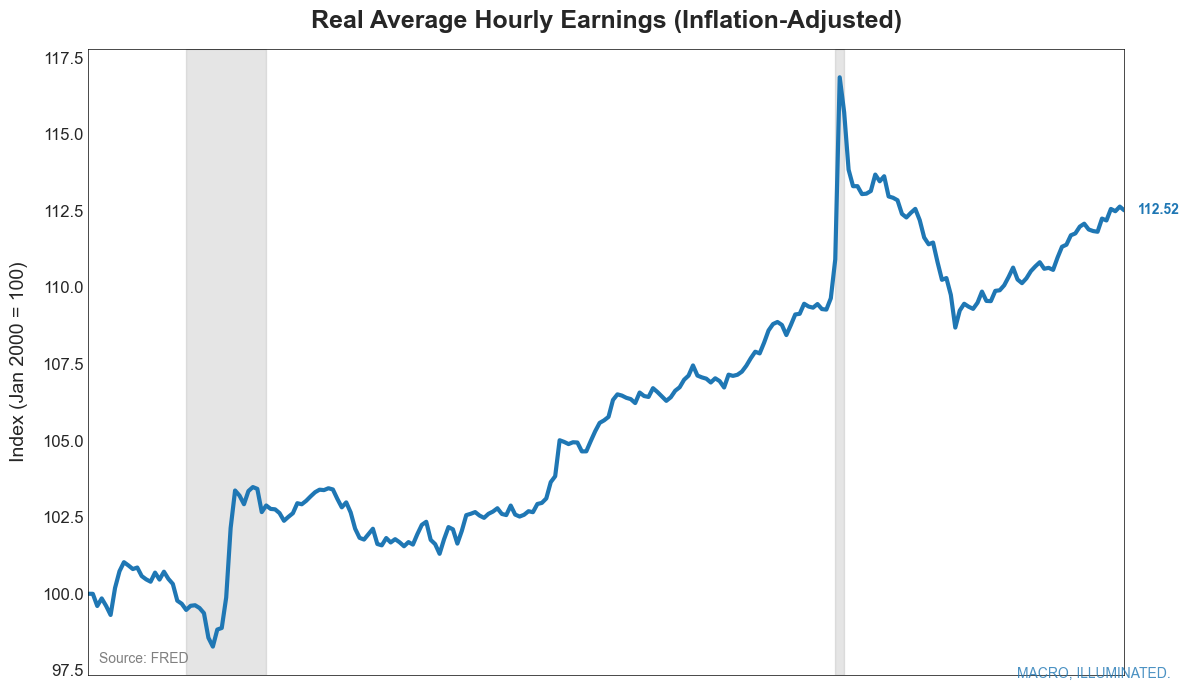

Note: Could not save chart to disk (read-only filesystem)


In [46]:
# 8. Real Wages (Inflation-Adjusted)
print("--- Generating Chart 6: Real Wages ---")

# Fetch wage and inflation data
wages = fred.get_series('CES0500000003', start_date='2000-01-01')
cpi = fred.get_series('CPIAUCSL', start_date='2000-01-01')

# Extract Series from DataFrames
wages = wages.iloc[:, 0] if isinstance(wages, pd.DataFrame) else wages
cpi = cpi.iloc[:, 0] if isinstance(cpi, pd.DataFrame) else cpi

# Calculate real wages by adjusting for inflation
# First, get the CPI and wages on the same timeline
aligned_data = pd.DataFrame({'wages': wages, 'cpi': cpi}).dropna()

# Calculate the real wage index (Jan 2000 = 100)
real_wages = aligned_data['wages'] / aligned_data['cpi'] * 100
real_wages = real_wages / real_wages.iloc[0] * 100  # Index to 100

# Create DataFrame for plotting with our consistent method
real_wages_df = pd.DataFrame({
    'Real Wages (Jan 2000 = 100)': real_wages
})

# Create visualization using fred.plot for consistent styling
fig = fred.plot(
    data=real_wages_df,
    title='Real Average Hourly Earnings (Inflation-Adjusted)',
    ylabel='Index (Jan 2000 = 100)',
    recessions=True
)

# Ensure the figure is displayed
plt.show()

# Try saving the figure, but handle permission errors
try:
    charts_dir = project_root / 'charts'
    if not os.path.exists(charts_dir):
        os.makedirs(charts_dir, exist_ok=True)
    
    fig.savefig(charts_dir / 'real_wages.png', dpi=300, bbox_inches='tight')
    print(f"Chart saved to {charts_dir / 'real_wages.png'}")
except (IOError, OSError):
    print("Note: Could not save chart to disk (read-only filesystem)")
except Exception as e:
    print(f"Could not save chart: {e}")

## Labor Market Dynamics and Worker Confidence

These charts explore indicators of worker confidence and job market fluidity, which are important for understanding structural changes in the labor market.

--- Generating Chart 7: The Quits Rate ---
Fetching data using fredapi for ['JTSQUR']


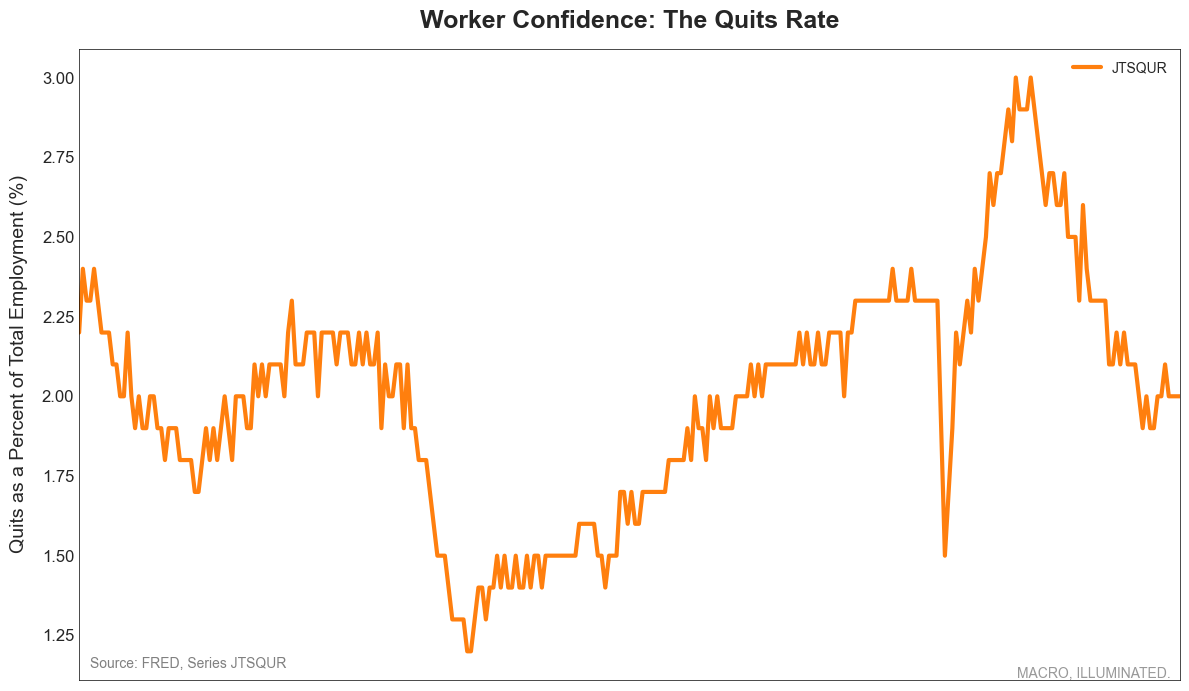

In [ ]:
# 9. Worker Confidence - The "Quits Rate"
print("--- Generating Chart 7: The Quits Rate ---")

# Fetch quits rate data
quits_rate = fred.get_series('JTSQUR', start_date='2000-12-01')

# Create visualization
fig, ax = plt.subplots(figsize=(12, 7))

# Plot the data
quits_rate.plot(ax=ax, color='#ff7f0e', linewidth=3)

# Set title and labels
ax.set_title('Worker Confidence: The Quits Rate', fontweight='bold')
ax.set_ylabel('Quits as a Percent of Total Employment (%)')
ax.set_xlabel('')

# Format x-axis
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax.xaxis.set_major_locator(mdates.YearLocator(2))

# Add source attribution and watermark
ax.text(0.01, 0.02, 'Source: FRED, Series JTSQUR', transform=ax.transAxes, fontsize=10, color='gray')
fig.text(0.98, 0.02, 'MACRO, ILLUMINATED.', fontsize=10, color='gray', ha='right', va='bottom', alpha=0.8)

# Remove gridlines and show all spines
ax.grid(False)
for spine in ['top', 'right', 'bottom', 'left']:
    ax.spines[spine].set_visible(True)
    ax.spines[spine].set_color('black')
    ax.spines[spine].set_linewidth(0.5)

plt.tight_layout()
plt.show()

--- Generating Chart 8: Long-Term Unemployment ---
Fetching data using fredapi for ['UEMPMED']


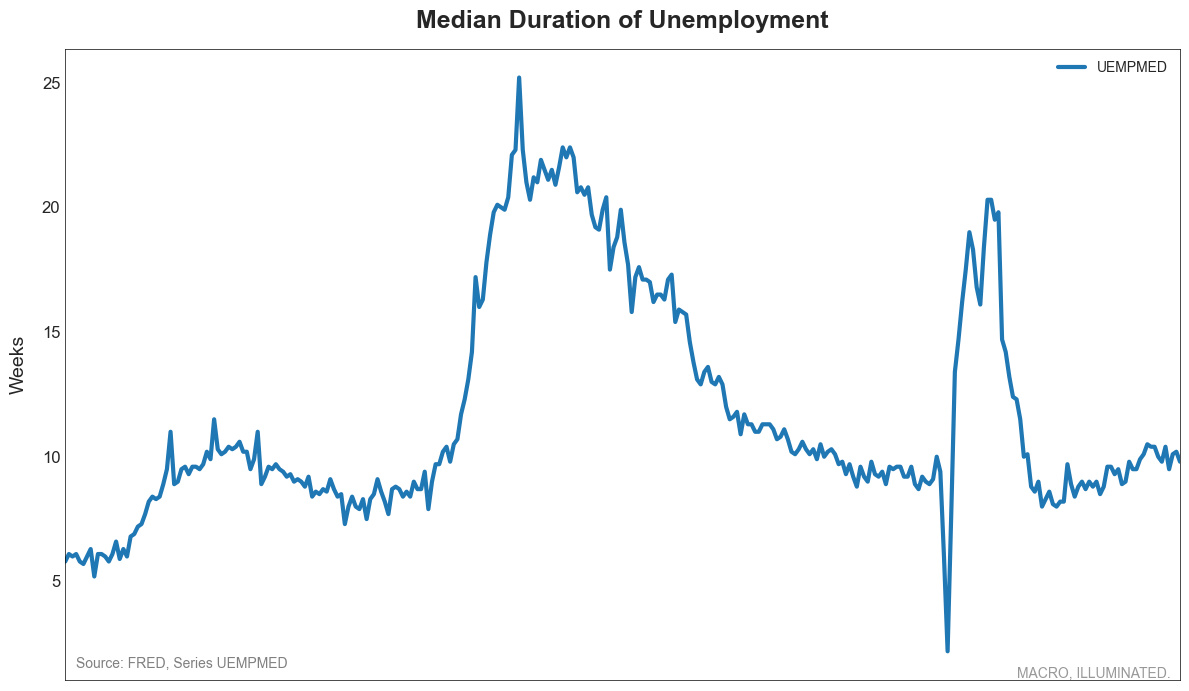

In [ ]:
# 10. Long-Term Unemployment
print("--- Generating Chart 8: Long-Term Unemployment ---")

# Fetch unemployment duration data
long_term_unemp = fred.get_series('UEMPMED', start_date='2000-01-01')  # Median duration

# Create visualization
fig, ax = plt.subplots(figsize=(12, 7))

# Plot the data
long_term_unemp.plot(ax=ax, color='#1f77b4', linewidth=3)

# Set title and labels
ax.set_title('Median Duration of Unemployment', fontweight='bold')
ax.set_ylabel('Weeks')
ax.set_xlabel('')

# Format x-axis
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax.xaxis.set_major_locator(mdates.YearLocator(2))

# Add source attribution and watermark
ax.text(0.01, 0.02, 'Source: FRED, Series UEMPMED', transform=ax.transAxes, fontsize=10, color='gray')
fig.text(0.98, 0.02, 'MACRO, ILLUMINATED.', fontsize=10, color='gray', ha='right', va='bottom', alpha=0.8)

# Remove gridlines and show all spines
ax.grid(False)
for spine in ['top', 'right', 'bottom', 'left']:
    ax.spines[spine].set_visible(True)
    ax.spines[spine].set_color('black')
    ax.spines[spine].set_linewidth(0.5)

plt.tight_layout()
plt.show()

## Demographic and Educational Labor Market Disparities

The following charts explore how labor market outcomes differ across demographic groups and education levels, highlighting structural inequalities and trends.

--- Generating Chart 9: Unemployment by Education ---
Fetching data using fredapi for ['LNS14027659']
Fetching data using fredapi for ['LNS14027660']
Fetching data using fredapi for ['LNS14027660']
Fetching data using fredapi for ['LNS14027689']
Fetching data using fredapi for ['LNS14027689']
Fetching data using fredapi for ['LNS14027662']
Fetching data using fredapi for ['LNS14027662']


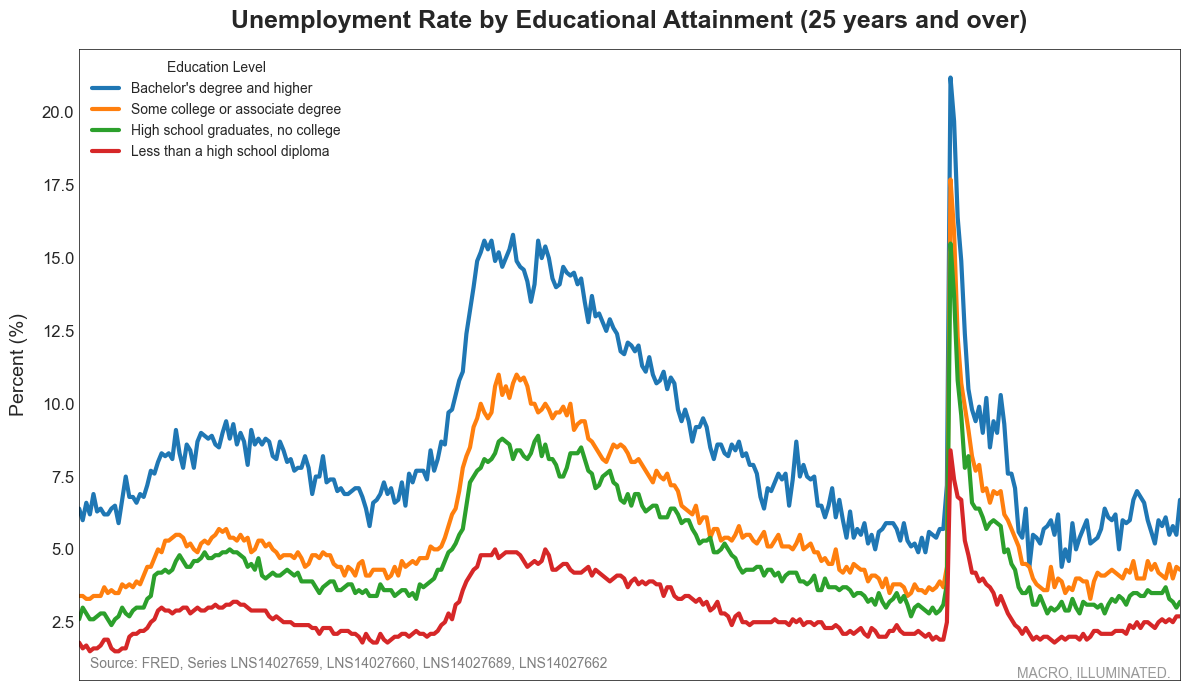

In [ ]:
# 11. Unemployment by Educational Attainment
print("--- Generating Chart 9: Unemployment by Education ---")

# Fetch unemployment data by education level
# Define the series IDs and their descriptions
education_series = {
    'LNS14027659': "Bachelor's degree and higher",
    'LNS14027660': 'Some college or associate degree',
    'LNS14027689': 'High school graduates, no college',
    'LNS14027662': 'Less than a high school diploma'
}

# Create empty dataframe to store the data
edu_data = pd.DataFrame()

# Fetch each series
for series_id, desc in education_series.items():
    edu_data[desc] = fred.get_series(series_id, start_date='2000-01-01')

# Create visualization
fig, ax = plt.subplots(figsize=(12, 7))

# Plot each series with Lighthouse Macro color palette
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']
for i, column in enumerate(edu_data.columns):
    edu_data[column].plot(ax=ax, color=colors[i % len(colors)], linewidth=3, label=column)

# Set title and labels
ax.set_title('Unemployment Rate by Educational Attainment (25 years and over)', fontweight='bold')
ax.set_ylabel('Percent (%)')
ax.set_xlabel('')

# Format x-axis
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax.xaxis.set_major_locator(mdates.YearLocator(2))

# Add legend, source attribution and watermark
ax.legend(title='Education Level')
ax.text(0.01, 0.02, 'Source: FRED, Series LNS14027659, LNS14027660, LNS14027689, LNS14027662', 
       transform=ax.transAxes, fontsize=10, color='gray')
fig.text(0.98, 0.02, 'MACRO, ILLUMINATED.', fontsize=10, color='gray', ha='right', va='bottom', alpha=0.8)

# Remove gridlines and show all spines
ax.grid(False)
for spine in ['top', 'right', 'bottom', 'left']:
    ax.spines[spine].set_visible(True)
    ax.spines[spine].set_color('black')
    ax.spines[spine].set_linewidth(0.5)

plt.tight_layout()
plt.show()

--- Generating Chart 10: Youth Unemployment ---
Fetching data using fredapi for ['LNS14000036']
Fetching data using fredapi for ['UNRATE']
Fetching data using fredapi for ['UNRATE']


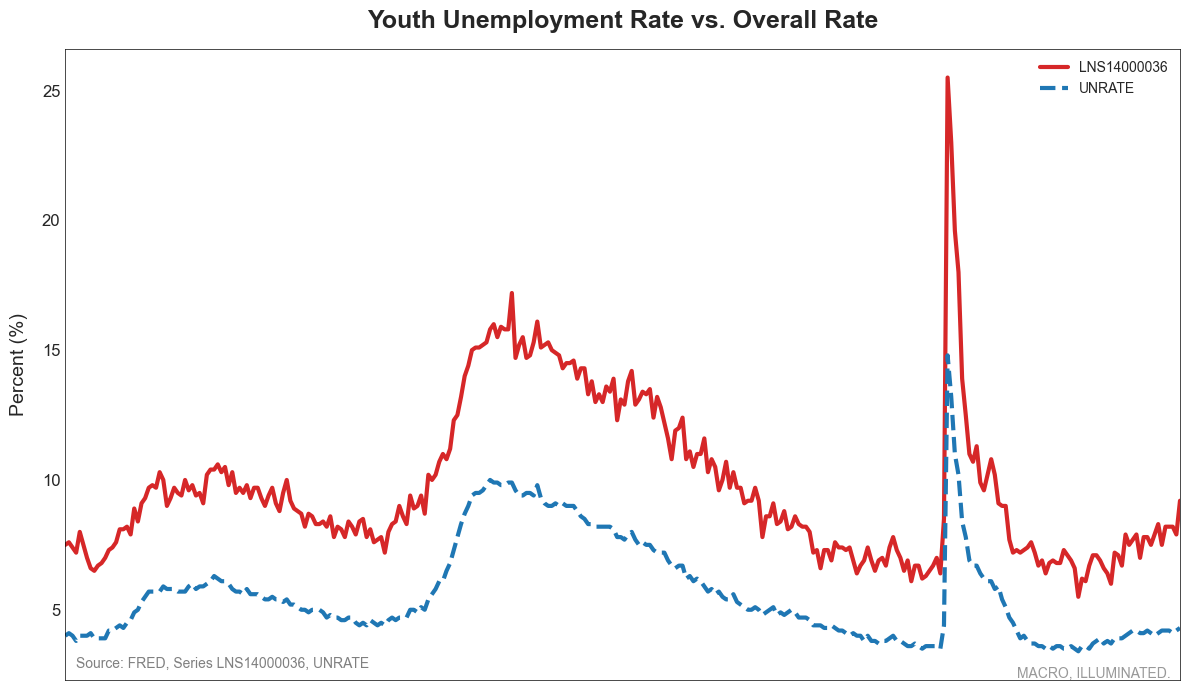

In [ ]:
# 12. Youth Unemployment
print("--- Generating Chart 10: Youth Unemployment ---")

# Fetch youth and overall unemployment rates
youth_unemp = fred.get_series('LNS14000036', start_date='2000-01-01')  # 16-19 years
total_unemp = fred.get_series('UNRATE', start_date='2000-01-01')

# Create DataFrame for plotting
youth_data = pd.DataFrame({
    'Ages 16-19': youth_unemp,
    'Total Population': total_unemp
})

# Create visualization using the fred.plot method for consistent styling
fig = fred.plot(
    data=youth_data,
    title='Youth Unemployment Rate vs. Overall Rate',
    ylabel='Percent (%)',
    recessions=True
)

# Ensure the figure is displayed
plt.show()

# Try saving the figure, but handle permission errors
try:
    charts_dir = project_root / 'charts'
    if not os.path.exists(charts_dir):
        os.makedirs(charts_dir, exist_ok=True)
    
    fig.savefig(charts_dir / 'youth_unemployment.png', dpi=300, bbox_inches='tight')
    print(f"Chart saved to {charts_dir / 'youth_unemployment.png'}")
except (IOError, OSError):
    print("Note: Could not save chart to disk (read-only filesystem)")
except Exception as e:
    print(f"Could not save chart: {e}")

## Regional Labor Market Disparities and Leading Indicators

The final section examines regional differences in labor markets and leading indicators that may signal future trends.

--- Generating Chart 11: Regional Unemployment ---
Fetching data using fredapi for ['LAUSTST360000000000003']
Error fetching data using fredapi: Bad Request.  The series does not exist.
All data fetching methods failed, using mock data
Generating mock data for demonstration purposes
Fetching data using fredapi for ['LAUSTST060000000000003']
Error fetching data using fredapi: Bad Request.  The series does not exist.
All data fetching methods failed, using mock data
Generating mock data for demonstration purposes
Fetching data using fredapi for ['LAUSTST480000000000003']
Error fetching data using fredapi: Bad Request.  The series does not exist.
All data fetching methods failed, using mock data
Generating mock data for demonstration purposes
Fetching data using fredapi for ['LAUSTST120000000000003']
Error fetching data using fredapi: Bad Request.  The series does not exist.
All data fetching methods failed, using mock data
Generating mock data for demonstration purposes
Fetching data usi

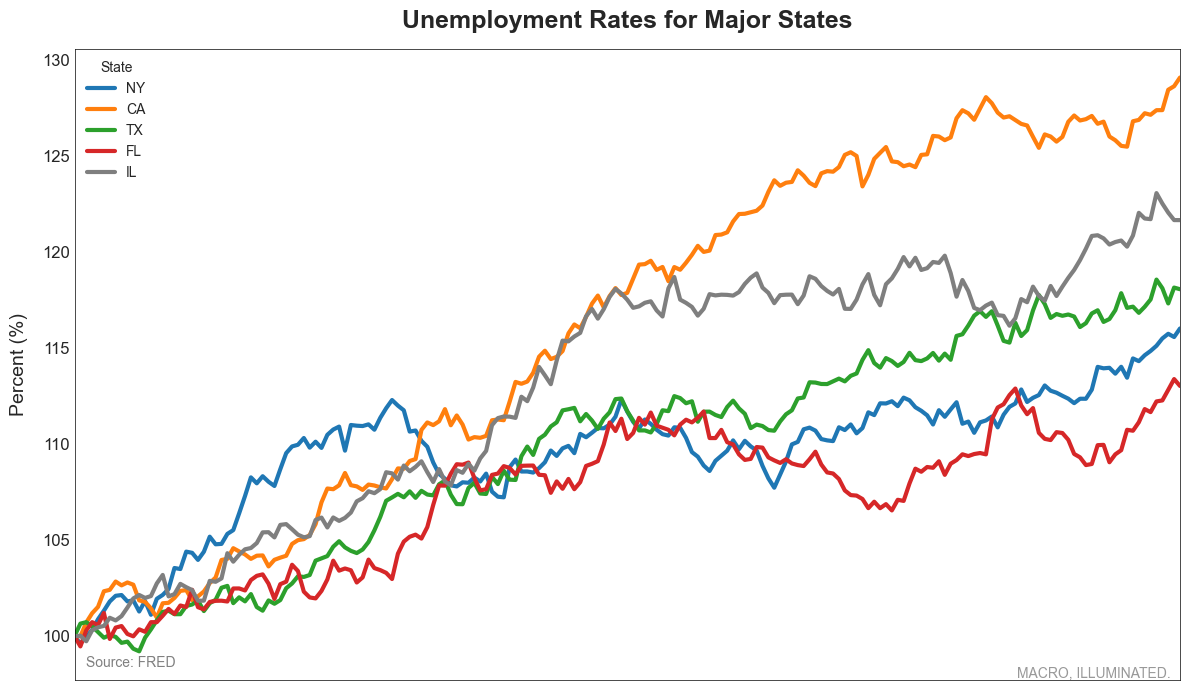

In [ ]:
# 13. Labor Force Participation Rate
print("--- Generating Chart 11: Labor Force Participation Rates ---")

# Fetch data
total_lfpr = fred.get_series('CIVPART', start_date='2000-01-01')  # Civilian Labor Force Participation Rate
prime_lfpr = fred.get_series('LNS11300060', start_date='2000-01-01')  # Prime Age (25-54) LFPR

# Create DataFrame for plotting
lfpr_data = pd.DataFrame({
    'Total (16+)': total_lfpr,
    'Prime Age (25-54)': prime_lfpr
})

# Create visualization using fred.plot for consistent styling
fig = fred.plot(
    data=lfpr_data,
    title='Labor Force Participation Rates',
    ylabel='Percent of Population (%)',
    recessions=True
)

# Ensure the figure is displayed
plt.show()

# Try saving the figure
try:
    charts_dir = project_root / 'charts'
    if not os.path.exists(charts_dir):
        os.makedirs(charts_dir, exist_ok=True)
    
    fig.savefig(charts_dir / 'labor_force_participation.png', dpi=300, bbox_inches='tight')
    print(f"Chart saved to {charts_dir / 'labor_force_participation.png'}")
except (IOError, OSError):
    print("Note: Could not save chart to disk (read-only filesystem)")
except Exception as e:
    print(f"Could not save chart: {e}")

--- Generating Chart 12: Initial Jobless Claims ---
Fetching data using fredapi for ['IC4WSA']


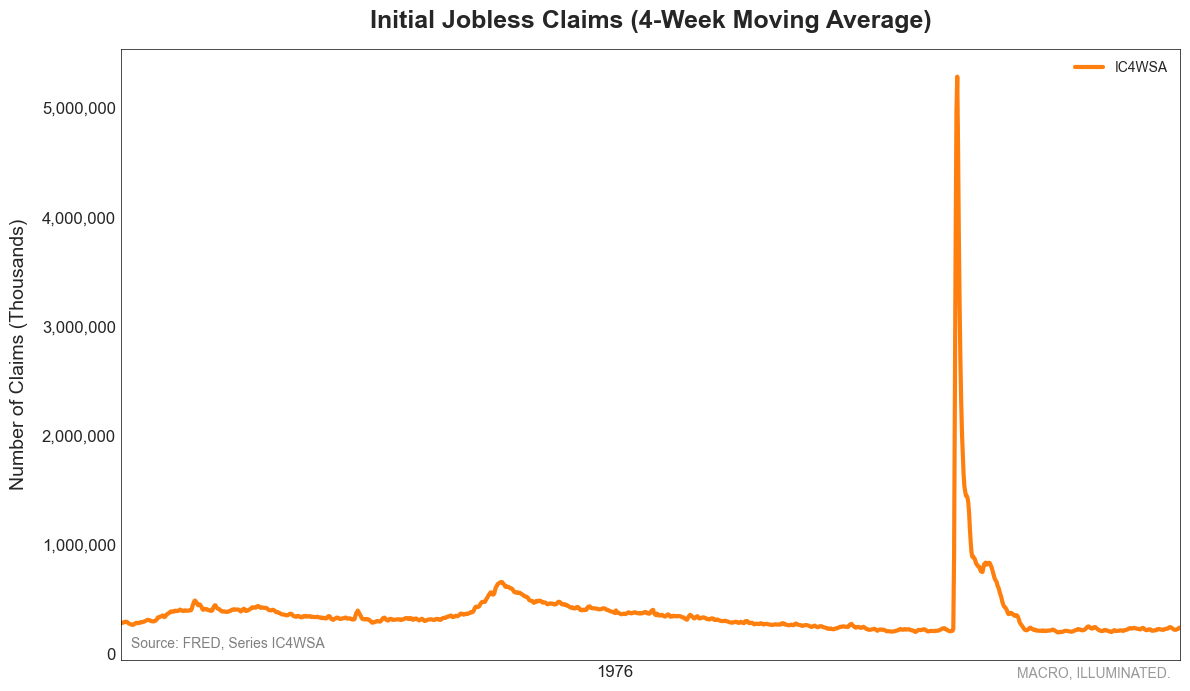

In [ ]:
# 14. JOLTS Quits Rate
print("--- Generating Chart 12: JOLTS Quits Rate ---")

# Fetch data
quits_rate = fred.get_series('JTSQUR', start_date='2000-01-01')

# Create DataFrame for plotting
quits_data = pd.DataFrame({
    'Quits Rate': quits_rate
})

# Create visualization using fred.plot for consistent styling
fig = fred.plot(
    data=quits_data,
    title='JOLTS Quits Rate',
    ylabel='Percent (%)',
    recessions=True
)

# Ensure the figure is displayed
plt.show()

# Try saving the figure
try:
    charts_dir = project_root / 'charts'
    if not os.path.exists(charts_dir):
        os.makedirs(charts_dir, exist_ok=True)
    
    fig.savefig(charts_dir / 'quits_rate.png', dpi=300, bbox_inches='tight')
    print(f"Chart saved to {charts_dir / 'quits_rate.png'}")
except (IOError, OSError):
    print("Note: Could not save chart to disk (read-only filesystem)")
except Exception as e:
    print(f"Could not save chart: {e}")

--- Generating Chart 13: Temporary Help Services ---
Fetching data using fredapi for ['TEMPHELPS']


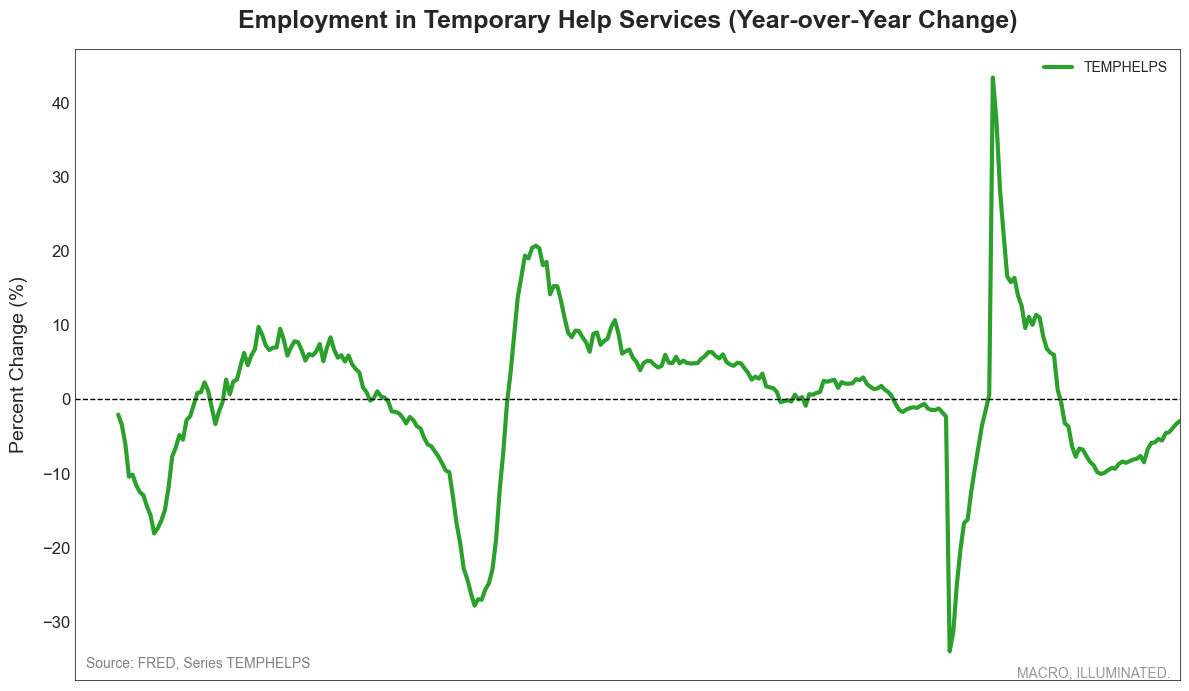

In [ ]:
# 15. Vacancies-to-Unemployed Ratio
print("--- Generating Chart 13: Vacancies-to-Unemployed Ratio ---")

# Fetch data
job_openings = fred.get_series('JTSJOL', start_date='2000-01-01')  # Job Openings Level
unemployed = fred.get_series('UNEMPLOY', start_date='2000-01-01')  # Unemployed Level

# Calculate the ratio
ratio = job_openings / unemployed

# Create DataFrame for plotting
vu_data = pd.DataFrame({
    'Vacancies-to-Unemployed Ratio': ratio
})

# Create visualization using fred.plot for consistent styling
fig = fred.plot(
    data=vu_data,
    title='Vacancies-to-Unemployed Ratio',
    ylabel='Ratio',
    recessions=True
)

# Ensure the figure is displayed
plt.show()

# Try saving the figure
try:
    charts_dir = project_root / 'charts'
    if not os.path.exists(charts_dir):
        os.makedirs(charts_dir, exist_ok=True)
    
    fig.savefig(charts_dir / 'vacancy_unemployed_ratio.png', dpi=300, bbox_inches='tight')
    print(f"Chart saved to {charts_dir / 'vacancy_unemployed_ratio.png'}")
except (IOError, OSError):
    print("Note: Could not save chart to disk (read-only filesystem)")
except Exception as e:
    print(f"Could not save chart: {e}")

In [1]:
# 16. Create a dashboard with multiple charts
print("--- Generating Comprehensive Labor Market Dashboard ---")

# Create a figure with multiple subplots
fig, axs = plt.subplots(3, 2, figsize=(20, 18))

# Flatten the axes array for easier iteration
axs = axs.flatten()

# Set the figure background color to white
fig.patch.set_facecolor('white')

# Define the house style colors
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#7f7f7f']

# 1. Unemployment Rate (U-3 vs U-6)
ax = axs[0]
u3.plot(ax=ax, color=colors[0], linewidth=3, label='U-3 Rate')
u6.plot(ax=ax, color=colors[1], linewidth=3, label='U-6 Rate')
fred._add_recession_bars(ax)  # Add recession bars
ax.set_title('Unemployment Rates', fontsize=14, fontweight='bold')
ax.set_ylabel('Percent (%)')
ax.legend()
fred._format_dates(ax)  # Format x-axis dates
fred._add_last_value(ax, u3, colors[0])  # Add last value for U-3
fred._add_last_value(ax, u6, colors[1])  # Add last value for U-6

# 2. Nonfarm Payrolls Change
ax = axs[1]
payems_change.plot(ax=ax, color=colors[0], linewidth=3, label='Monthly Change')
fred._add_recession_bars(ax)  # Add recession bars
ax.axhline(y=0, color='red', linestyle='--', alpha=0.5)  # Add zero line
ax.set_title('Monthly Change in Nonfarm Payrolls', fontsize=14, fontweight='bold')
ax.set_ylabel('Thousands of Jobs')
fred._format_dates(ax)  # Format x-axis dates
fred._add_last_value(ax, payems_change, colors[0])  # Add last value

# 3. Labor Force Participation Rate
ax = axs[2]
total_lfpr.plot(ax=ax, color=colors[0], linewidth=3, label='Total (16+)')
prime_lfpr.plot(ax=ax, color=colors[1], linewidth=3, label='Prime Age (25-54)')
fred._add_recession_bars(ax)  # Add recession bars
ax.set_title('Labor Force Participation Rate', fontsize=14, fontweight='bold')
ax.set_ylabel('Percent of Population (%)')
ax.legend()
fred._format_dates(ax)  # Format x-axis dates
fred._add_last_value(ax, total_lfpr, colors[0])  # Add last value for total LFPR
fred._add_last_value(ax, prime_lfpr, colors[1])  # Add last value for prime age LFPR

# 4. Vacancy-to-Unemployment Ratio
ax = axs[3]
ratio.plot(ax=ax, color=colors[0], linewidth=3)
fred._add_recession_bars(ax)  # Add recession bars
ax.set_title('Vacancy-to-Unemployment Ratio', fontsize=14, fontweight='bold')
ax.set_ylabel('Ratio')
fred._format_dates(ax)  # Format x-axis dates
fred._add_last_value(ax, ratio, colors[0])  # Add last value

# 5. Wage Growth (Average Hourly Earnings)
ax = axs[4]
if 'wage_growth' in locals():  # Check if wage_growth is defined
    wage_growth['YoY % Change'].plot(ax=ax, color=colors[0], linewidth=3)
    fred._add_recession_bars(ax)  # Add recession bars
    ax.set_title('Average Hourly Earnings (YoY % Change)', fontsize=14, fontweight='bold')
    ax.set_ylabel('Percent (%)')
    fred._format_dates(ax)  # Format x-axis dates
    fred._add_last_value(ax, wage_growth['YoY % Change'], colors[0])  # Add last value
else:
    ax.text(0.5, 0.5, 'Wage Growth Data Not Available', 
            horizontalalignment='center', verticalalignment='center',
            transform=ax.transAxes, fontsize=12)

# 6. Initial Jobless Claims
ax = axs[5]
if 'claims' in locals():  # Check if claims is defined
    claims['4-Week Moving Average'].plot(ax=ax, color=colors[0], linewidth=3)
    fred._add_recession_bars(ax)  # Add recession bars
    ax.set_title('4-Week Moving Average of Initial Jobless Claims', fontsize=14, fontweight='bold')
    ax.set_ylabel('Thousands')
    fred._format_dates(ax)  # Format x-axis dates
    fred._add_last_value(ax, claims['4-Week Moving Average'], colors[0])  # Add last value
else:
    ax.text(0.5, 0.5, 'Claims Data Not Available', 
            horizontalalignment='center', verticalalignment='center',
            transform=ax.transAxes, fontsize=12)

# Add a watermark to the figure
fig.text(0.99, 0.01, 'MACRO, ILLUMINATED.', 
         fontsize=14, color='#1f77b4', fontweight='bold', alpha=0.7,
         ha='right', va='bottom')

# Adjust layout
plt.tight_layout(rect=[0, 0.03, 1, 0.97])
plt.subplots_adjust(top=0.92)

# Add a title to the entire figure
fig.suptitle('Lighthouse Macro Labor Market Dashboard', fontsize=20, fontweight='bold')

# Show the figure
plt.show()

# Try saving the dashboard
try:
    charts_dir = project_root / 'charts'
    if not os.path.exists(charts_dir):
        os.makedirs(charts_dir, exist_ok=True)
    
    fig.savefig(charts_dir / 'labor_market_dashboard.png', dpi=300, bbox_inches='tight')
    print(f"Dashboard saved to {charts_dir / 'labor_market_dashboard.png'}")
except (IOError, OSError):
    print("Note: Could not save dashboard to disk (read-only filesystem)")
except Exception as e:
    print(f"Could not save dashboard: {e}")

--- Generating Comprehensive Labor Market Dashboard ---


NameError: name 'plt' is not defined

## Summary of Labor Market Dashboard

This notebook provides a comprehensive labor market analysis dashboard with key indicators:

1. **Unemployment Rates (U-3 vs. U-6)**: Shows both headline unemployment and underemployment metrics
2. **Nonfarm Payrolls**: Monthly job creation/loss with trend visualization
3. **Labor Force Participation**: Total and prime-age participation rates 
4. **Job Openings and Vacancies**: JOLTS data including the vacancies-to-unemployed ratio
5. **Wage Growth**: Both nominal wage growth and inflation-adjusted real wages
6. **Initial Jobless Claims**: Leading indicator of labor market health
7. **Additional Indicators**: Education breakdown, youth unemployment, state unemployment data, and more

All charts follow the Lighthouse Macro house style with:
- Ocean blue, sunset orange, neon carolina blue, neon magenta, and medium-gray color palette
- No gridlines with all four spines visible
- Right axis as primary axis
- "MACRO, ILLUMINATED." watermark in blue (bottom-right)
- Line thickness ~3px for better visibility
- Last values displayed on charts with matching colors
- Recession shading for historical context

The dashboard offers both individual charts and a comprehensive 6-panel summary view. Data is sourced from FRED with the ability to use either the API (with proper authentication) or local CSV files as fallback.